## A quick look at Residential housing in Philadelphia

Data gathered from [opendataphilly](https://www.opendataphilly.org/dataset/opa-property-assessments) using the [Socrata API](https://dev.socrata.com/foundry/data.phila.gov/tqtk-pmbv) to filter dataset.

I would like to use this to help find properties built before 1978 (the year a ban against using lead in paint came into effect).

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

In [2]:
# use pandas to read csv and store as dataframe object 
buildings = pd.read_csv('data/properties.csv', dtype={'census_tract': object} )

In [3]:
#quick look at dataframe
buildings.info()
buildings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580042 entries, 0 to 580041
Data columns (total 7 columns):
census_tract           580042 non-null object
coordinates            578737 non-null object
location               580042 non-null object
street_name            580042 non-null object
year_built             528014 non-null float64
year_built_estimate    439123 non-null object
zip_code               580037 non-null float64
dtypes: float64(2), object(5)
memory usage: 31.0+ MB


,census_tract,coordinates,location,street_name,year_built,year_built_estimate,zip_code
0,023,POINT (-75.162942 39.933671),1119 WHARTON ST,WHARTON,1915.0,NaN,191475003.0
1,083,POINT (-75.240782 39.953394),514 S 59TH ST,59TH,1925.0,NaN,191431915.0
2,083,POINT (-75.240929 39.9527),546 S 59TH ST,59TH,1925.0,NaN,191431915.0
3,082,POINT (-75.241263 39.951092),640 S 59TH ST,59TH,1925.0,Y,191432433.0
4,201,POINT (-75.154961 40.00141),1500 W ALLEGHENY AVE,ALLEGHENY,1925.0,NaN,191321715.0


The accuracy of the data is important. Knowing exact dates of the buildings construction will be helpful in determining the possibility of lead contamination. An estimated date is still helpful - materials and styles of building have not changed greatly from year to year. We are going to be looking at all buildings built (or estimated to have been built) prior to 1978 (when lead paint was banned). As we can see below, an outstanding majority of the buildings in the dataset have had their dates estimated.

Using the `value_counts` method counts the number of occurances of a specified value.

In [4]:
estimate_counts = buildings['year_built_estimate'].value_counts()
estimate_counts

Y    438729
N       382
0        12
Name: year_built_estimate, dtype: int64

To find the 10 most commonly occuring street in the data set we run code similar to the above code but instead of counting the column `year_built_estimate` we look at `street_name`.

In [60]:
street_counts = buildings['street_name'].value_counts()
#show the 10 streets with highest number of residential buildings
street_counts[:10]

LOCUST    3166
06TH      3012
02ND      2967
18TH      2841
05TH      2728
SPRUCE    2671
16TH      2654
07TH      2605
08TH      2588
17TH      2587
Name: street_name, dtype: int64

In order to plot this we need to import matplotlib and add juypter magic to allow it to show the plot inline:

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

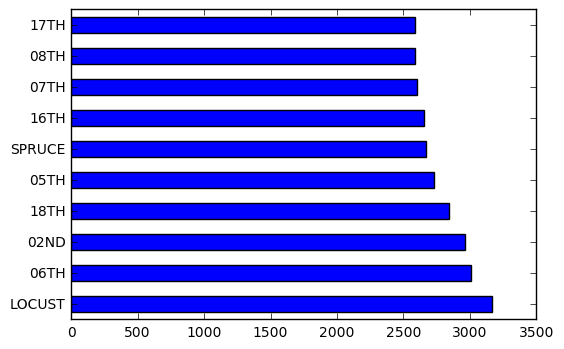

In [63]:
plt.figure()
street_counts[:10].plot(kind='barh', rot=0)

---

I now want to look at each street and find how many houses are pre 1978 and how many are post 1978.

The column for `year_built` has some values that are null and will give errors if we tried to count them. What we need to do is create a subset of the data, ignoring all values that are null. I have called the new datafram `cframe` for clean frame. It contains the `year_built` column but only includes the cells that are _not null_


In [64]:
cframe = buildings[buildings.year_built.notnull()]

Now I want to create an array splitting pre and post 1978 housing. Im using numpy.

In [65]:
year_prepost = np.where(cframe['year_built'] < 1978,
                            'Pre 1978', 'Post 1978')
year_prepost[:20]

array(['Pre 1978', 'Pre 1978', 'Pre 1978', 'Pre 1978', 'Pre 1978',
       'Pre 1978', 'Pre 1978', 'Pre 1978', 'Pre 1978', 'Pre 1978',
       'Post 1978', 'Post 1978', 'Pre 1978', 'Post 1978', 'Pre 1978',
       'Pre 1978', 'Pre 1978', 'Pre 1978', 'Pre 1978', 'Post 1978'], 
      dtype='<U9')

Now group the pre / post array by street name - this could also be done by zip code or census tract (why not try that too!)  **try to work out why it doesn't work with zip code**. Could you fix it?

In [69]:
by_year_street = cframe.groupby(['street_name', year_prepost])

In [70]:
agg_counts = by_year_street.size().unstack().fillna(0)

In [71]:
agg_counts[:10]

,Post 1978,Pre 1978
street_name,,
02ND,700.0,1887.0
03RD,209.0,1743.0
04TH,221.0,1882.0
05TH,152.0,2156.0
06TH,611.0,2037.0
07TH,147.0,2095.0
08TH,109.0,2185.0
09TH,91.0,1787.0
10TH,57.0,1668.0


In [72]:
# Use to sort in ascending order
indexer = agg_counts.sum(1).argsort()
indexer[:10]

street_name
02ND     354
03RD     346
04TH    2353
05TH     765
06TH     710
07TH     713
08TH    2485
09TH     211
10TH    1688
11TH    1804
dtype: int64

In [73]:
count_subset = agg_counts.take(indexer)[-10:]
count_subset

,Post 1978,Pre 1978
street_name,,
CHESTNUT,39.0,2253.0
08TH,109.0,2185.0
05TH,152.0,2156.0
16TH,251.0,2073.0
WALNUT,694.0,1644.0
02ND,700.0,1887.0
SPRUCE,56.0,2541.0
06TH,611.0,2037.0
18TH,325.0,2325.0


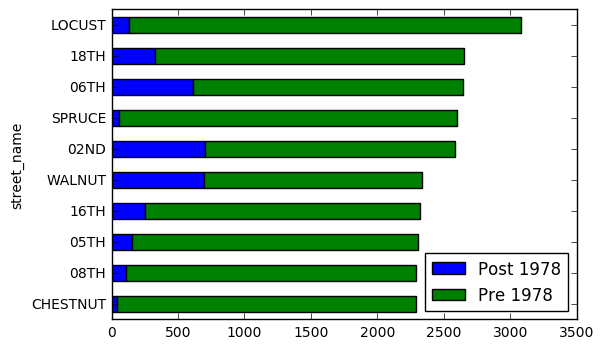

In [74]:
plt.figure()
count_subset.plot(kind='barh', stacked=True)